In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Use Agg backend to avoid issues when running headless
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Switching backend for plt if only plt is used

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Enable inline plotting if running in a notebook
%matplotlib inline

# Set plot style for consistency
sns.set(style='whitegrid')


In [3]:

df = pd.read_csv('upi_transactions_2024.csv', encoding='ascii', delimiter=',')

# Display basic information
print('Dataset Shape:', df.shape)
print('Columns:', df.columns.tolist())

# Convert 'timestamp' column to datetime type
# It is important to check for any errors during the datetime conversion
try:
    df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True, errors='raise')
except Exception as e:
    # Other notebook creators may encounter format inconsistencies. Handling errors here is essential.
    print('Error parsing timestamp:', e)

# Display datatypes for verification
print(df.dtypes)

Dataset Shape: (250000, 17)
Columns: ['transaction id', 'timestamp', 'transaction type', 'merchant_category', 'amount (INR)', 'transaction_status', 'sender_age_group', 'receiver_age_group', 'sender_state', 'sender_bank', 'receiver_bank', 'device_type', 'network_type', 'fraud_flag', 'hour_of_day', 'day_of_week', 'is_weekend']
transaction id                object
timestamp             datetime64[ns]
transaction type              object
merchant_category             object
amount (INR)                   int64
transaction_status            object
sender_age_group              object
receiver_age_group            object
sender_state                  object
sender_bank                   object
receiver_bank                 object
device_type                   object
network_type                  object
fraud_flag                     int64
hour_of_day                    int64
day_of_week                   object
is_weekend                     int64
dtype: object


In [4]:
print('Missing values per column:\n', df.isnull().sum())

# If missing values are found, one might consider imputation or removal based on context.
# For simplicity, if missing values exist, we will drop rows with missing data.
df.dropna(inplace=True)

# Verify cleaning result
print('Cleaned dataset shape:', df.shape)

# Convert categorical variables to type 'category' for efficient memory usage
categorical_cols = ['transaction id', 'transaction type', 'merchant_category', 'transaction_status',
                    'sender_age_group', 'receiver_age_group', 'sender_state', 'sender_bank',
                    'receiver_bank', 'device_type', 'network_type', 'day_of_week']

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

Missing values per column:
 transaction id        0
timestamp             0
transaction type      0
merchant_category     0
amount (INR)          0
transaction_status    0
sender_age_group      0
receiver_age_group    0
sender_state          0
sender_bank           0
receiver_bank         0
device_type           0
network_type          0
fraud_flag            0
hour_of_day           0
day_of_week           0
is_weekend            0
dtype: int64
Cleaned dataset shape: (250000, 17)


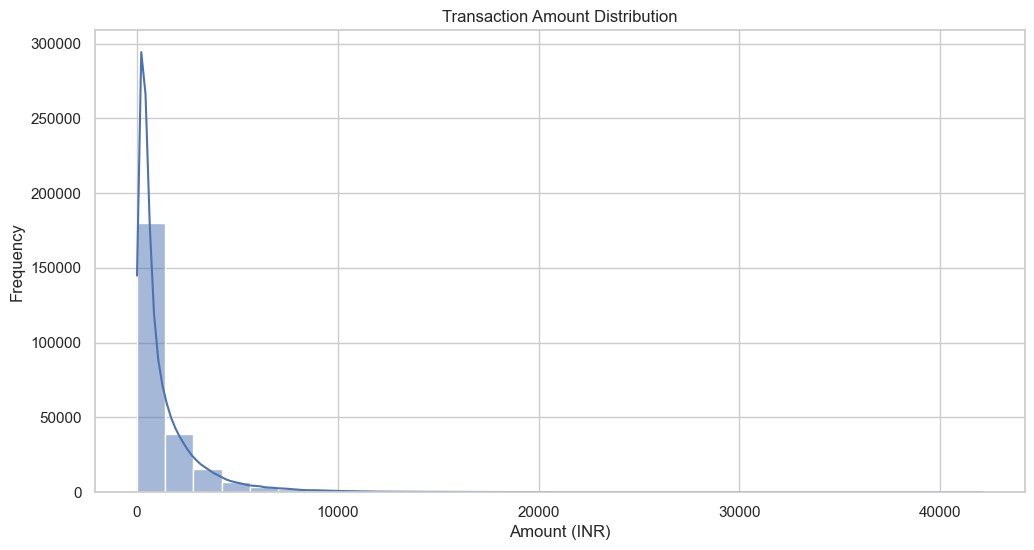

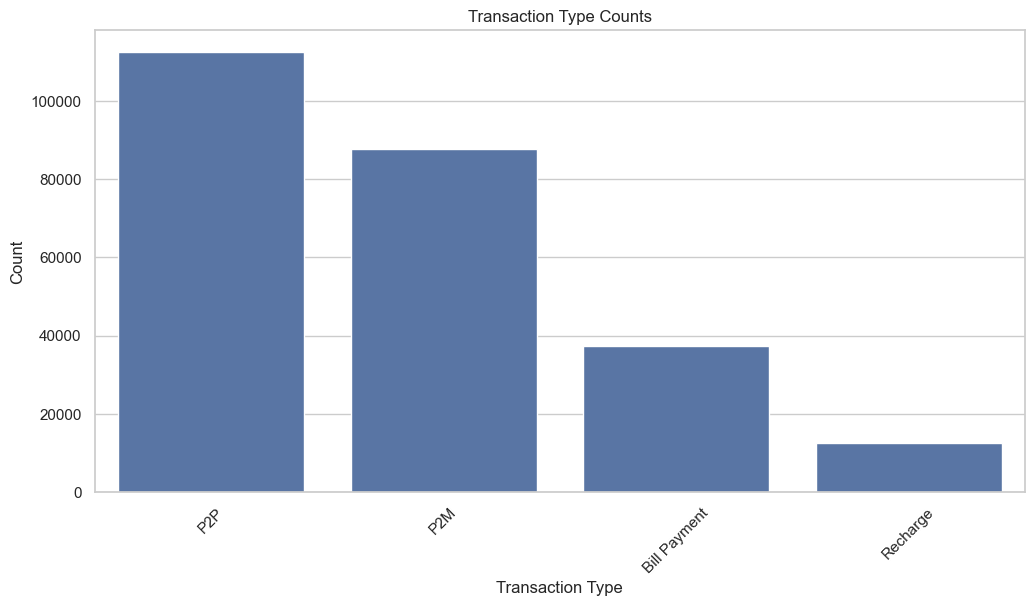

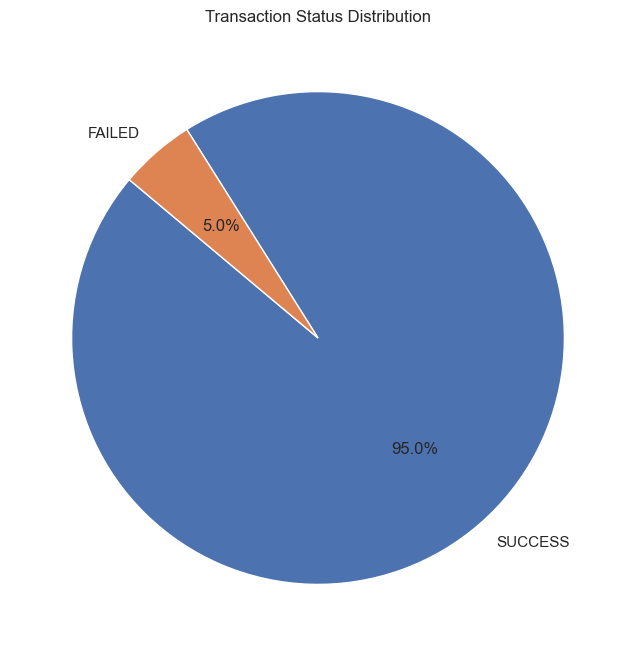

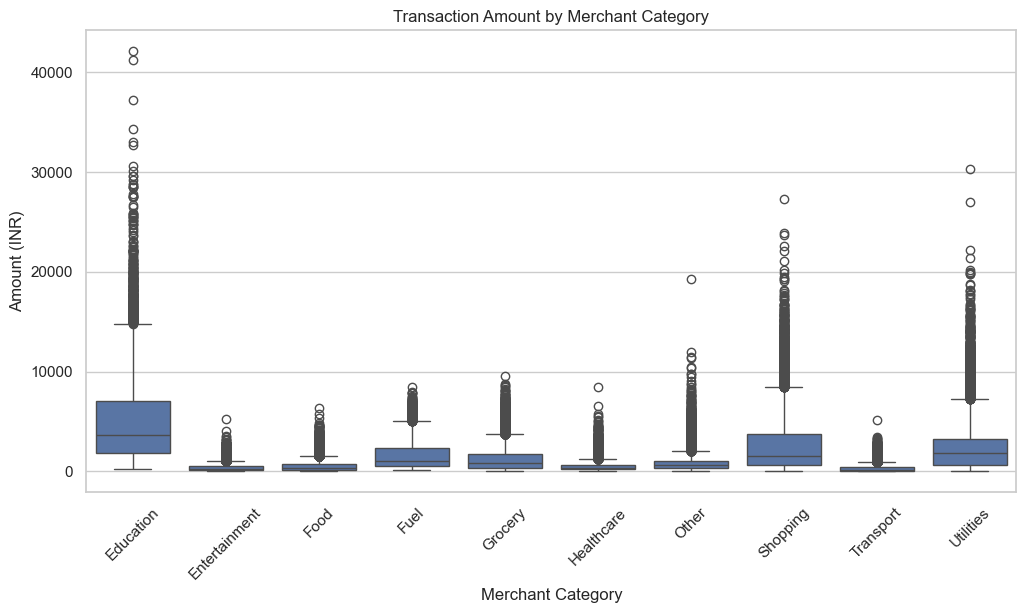

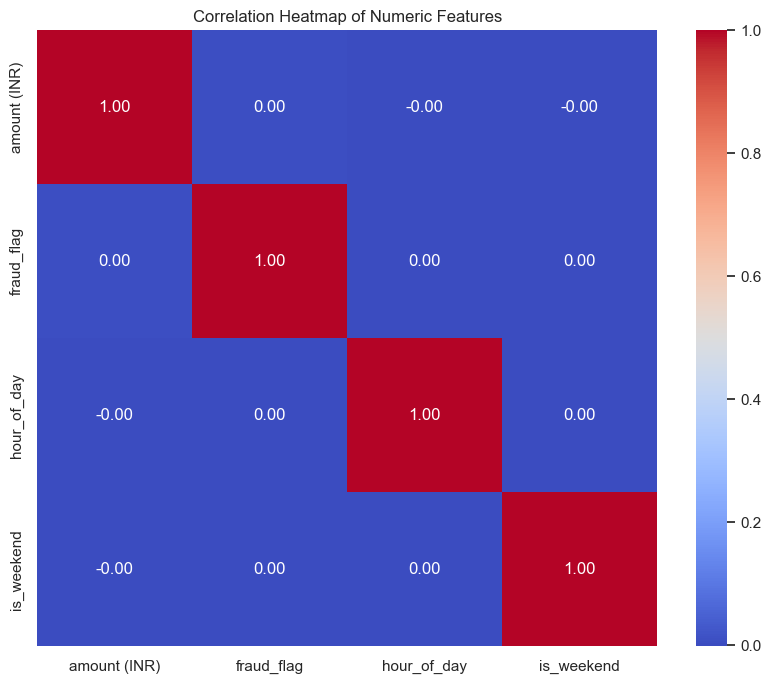

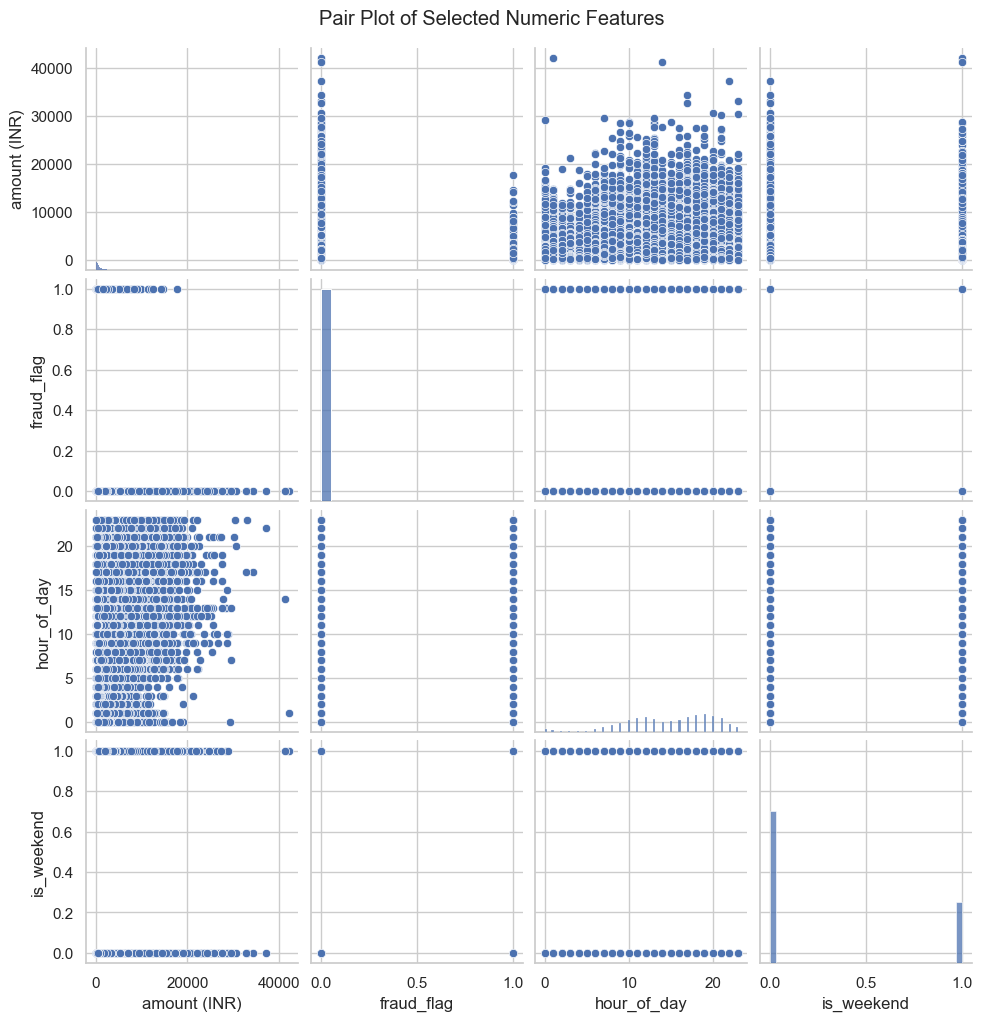

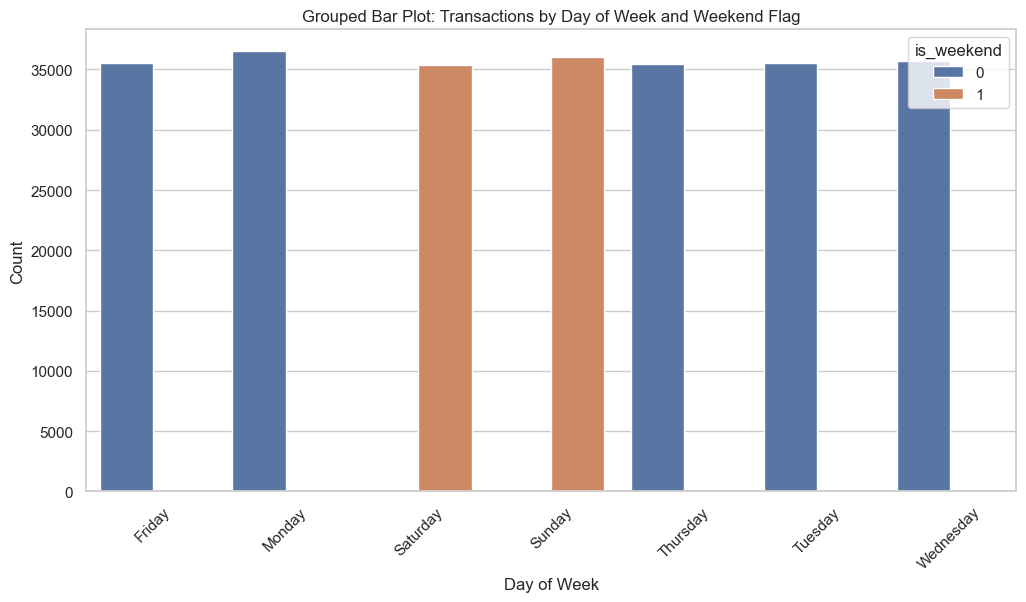

In [5]:
plt.figure(figsize=(12, 6))
sns.histplot(df['amount (INR)'], bins=30, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount (INR)')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='transaction type', order=df['transaction type'].value_counts().index)
plt.title('Transaction Type Counts')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Pie Chart using countplot for 'transaction_status'
plt.figure(figsize=(8, 8))
status_counts = df['transaction_status'].value_counts()
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Transaction Status Distribution')
plt.show()
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='merchant_category', y='amount (INR)')
plt.title('Transaction Amount by Merchant Category')
plt.xlabel('Merchant Category')
plt.ylabel('Amount (INR)')
plt.xticks(rotation=45)
plt.show()

# If there are at least 4 numeric features, generate a correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()
if set(['amount (INR)', 'fraud_flag', 'hour_of_day', 'is_weekend']).issubset(numeric_df.columns):
    sns.pairplot(df[['amount (INR)', 'fraud_flag', 'hour_of_day', 'is_weekend']])
    plt.suptitle('Pair Plot of Selected Numeric Features', y=1.02)
    plt.show()

# Grouped Bar Plot: Example: Transaction count by day_of_week and is_weekend
plt.figure(figsize=(12, 6))
grouped = df.groupby(['day_of_week', 'is_weekend']).size().reset_index(name='count')
sns.barplot(data=grouped, x='day_of_week', y='count', hue='is_weekend')
plt.title('Grouped Bar Plot: Transactions by Day of Week and Weekend Flag')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Logistic Regression Accuracy: 0.9982666666666666


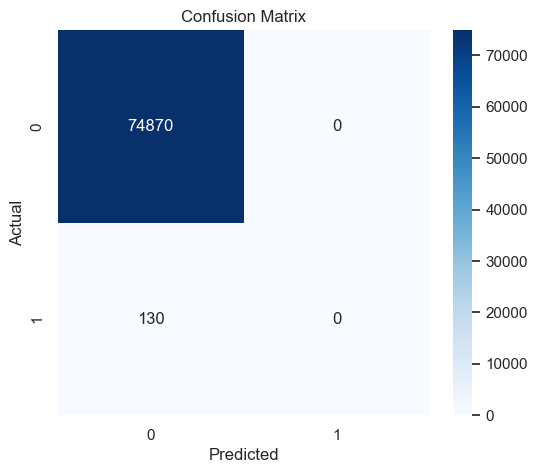

In [6]:
df_model = df.copy()

# For simplicity, drop columns that are not useful or redundant for prediction (e.g., 'transaction id', 'timestamp')
drop_cols = ['transaction id', 'timestamp']
df_model.drop(columns=drop_cols, inplace=True, errors='ignore')

# Identify features and target. Our target is 'fraud_flag'.
target = 'fraud_flag'
features = df_model.columns.drop(target)

# Prepare data: Encode categorical variables
le = LabelEncoder()
for col in features:
    if df_model[col].dtype.name == 'category' or df_model[col].dtype == object:
        df_model[col] = le.fit_transform(df_model[col])

# Separate features and target variable
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features since some models perform better with scaled data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Logistic Regression classifier
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Make predictions and evaluate accuracy
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Logistic Regression Accuracy:', accuracy)

# Generate and plot a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
def predict_transaction(input_data, model_type='rf'):
    """
    Predict whether a transaction is fraud or not.

    Parameters:
        input_data (dict): All feature columns except 'transaction id' and 'timestamp'.
        model_type (str): 'rf' for Random Forest or 'lr' for Logistic Regression.

    Returns:
        dict: Fraud prediction result with label and probability.
    """

    # Define columns to drop
    drop_cols = ['transaction id', 'timestamp']

    # Convert dict to DataFrame
    input_df = pd.DataFrame([input_data])

    # Drop unused columns if present
    input_df.drop(columns=[col for col in drop_cols if col in input_df.columns], inplace=True)

    # Encode all categorical columns using label encoding (same encoder assumed)
    for col in input_df.columns:
        if input_df[col].dtype == object:
            try:
                input_df[col] = le.transform(input_df[col])
            except ValueError as e:
                raise ValueError(f"Unknown category in column '{col}': {input_df[col].values[0]}")

    # Scale numeric features using previously fitted scaler
    input_scaled = scaler.transform(input_df)

    # Predict using selected model
    if model_type == 'rf':
        pred = rf_clf.predict(input_scaled)[0]
        prob = rf_clf.predict_proba(input_scaled)[0][1]
    elif model_type == 'lr':
        pred = log_reg.predict(input_scaled)[0]
        prob = log_reg.predict_proba(input_scaled)[0][1]
    else:
        raise ValueError("Invalid model_type. Use 'rf' or 'lr'.")

    return {
        'prediction': 'FRAUD' if pred == 1 else 'NOT FRAUD',
        'probability': round(prob, 4)
    }


In [12]:
sample_txn = {
    
    'merchant_category': 'Food',
    'amount (INR)': 1200,
    'transaction_status': 'SUCCESS',
    'sender_age_group': '26-35',
    'receiver_age_group': '18-25',
    'sender_state': 'Maharashtra',
    'sender_bank': 'SBI',
    'receiver_bank': 'HDFC',
    'device_type': 'Android',
    'network_type': '4G',
    'hour_of_day': 14,
    'day_of_week': 'Wednesday',
    'is_weekend': 0
}
result = predict_transaction(sample_txn, model_type='rf')
print(result)


ValueError: Unknown category in column 'transaction type': P2P